In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<br>
<br>
<br>
<br>

# **Preparação dos Dados (DataPrep) - Preliminar_02**

A etapa de preparação dos dados (dataprep) é crucial para o sucesso da modelagem de machine learning, pois os dados precisam estar limpos, organizados e em um formato adequado para serem utilizados pelos algoritmos de aprendizado de máquina. Isso inclui garantir a qualidade dos dados, ajustar o formato para atender aos requisitos dos algoritmos, garantir eficiência computacional, promover interpretabilidade e explicabilidade dos modelos e assegurar generalização e robustez.
<br>
<br>
Como agora se trata de um caso mais complexo, onde vamos treinar o modelo com a Regressão Logística e não se trata mais de um modelo baseline, vamos fazer o processo manualmente, passo por passo, sem o uso de pipeline, para ter um controle maior de cada etapa, caso seja necessário fazer algum ajuste específico, utilizar diferentes técnicas de pré-processamento e para permitir ter mais flexibilidade também.
<br>
<br>
Nesta etapa também iremos fazer a seleção das variáveis utilizando algumas das técnicas mais usadas, para que o nosso modelo seja treinado somente com as variáveis mais relevantes.
<br>
<br>
**Nota: Para otimizar o processamento dos dados e consumir a menor quantidade de memória possível, pois estamos com recursos limitados, farei a preparação dos dados em etapas. Primeiro vou fazer o DataPrep de cada book de variável com a base principal, fazer a seleção de variáveis e depois juntaremos todas as variáveis vindas de cada etapa para realizar o DataPrep final.**

<br>

## **Pacotes e Bibliotecas**

In [2]:
# Instalação dos Pacotes.
!pip install colorama > /dev/null

In [3]:
# Importando as bibliotecas Pandas e Numpy.
import pandas as pd
import numpy as np

# Importando as constantes definidas na biblioteca colorama que permitem alterar as cores e estilos de texto impresso no terminal.
from colorama import Fore, Style

# Importando a pickle para serialização.
import pickle

# Importando a função train_test_split para a divisão do nosso dataset em treino e teste.
from sklearn.model_selection import train_test_split

# Importando os algoritmos de Machine Learning, da biblioteca Scikit-Learn, que iremos utilizar nesse projeto.
from sklearn.ensemble import GradientBoostingClassifier

# Importando a biblioteca Matplotlib para plotarmos gráficos que ajudarão no entendimento dos dados.
import matplotlib.pyplot as plt

# Importando interface para o coletor de lixo (Garbage Collector) do Python.
import gc

<br>
<br>
<br>
<br>

## **Funções**

In [4]:
# Função para checar quantidade de linhas e colunas dos conjuntos de treino e teste.
def info_dataframe(treino, teste):
    '''
    Esta função exibe informações sobre a quantidade de linhas e colunas dos conjuntos de treino e teste.

    Parâmetros:
    - treino: DataFrame do conjunto de treino.
    - teste: DataFrame do conjunto de teste.

    Retorna:
    Um print com as informações.
    '''

    # Criando uma borda destacada para o título do conjunto de treino.
    print(Fore.BLUE + '=' * 45)
    print('CONJUNTO DE TREINO'.center(45))
    print('')
    print('Quantidade de linhas:', treino.shape[0])
    print('Quantidade de colunas:', treino.shape[1])
    print('=' * 45 + Style.RESET_ALL)
    print('')

    # Criando uma borda destacada para o título do conjunto de teste.
    print(Fore.GREEN + '=' * 45)
    print('CONJUNTO DE TESTE'.center(45))
    print('')
    print('Quantidade de linhas:', teste.shape[0])
    print('Quantidade de colunas:', teste.shape[1])
    print('=' * 45 + Style.RESET_ALL)



# =================================================================================================================================================== #



# Função para verificar os metadados do conjunto de dados.
def generate_metadata(df, ids, targets, orderby = 'PC_NULOS'):
    '''
    Esta função retorna uma tabela com informações descritivas sobre um DataFrame.

    Parâmetros:
    - df: DataFrame que você quer descrever.
    - ids: Lista de colunas que são identificadores.
    - targets: Lista de colunas que são variáveis alvo.
    - orderby: Ordenar por uma coluna específica.

    Retorna:
    Um DataFrame com informações sobre o df original.
    '''

    summary = pd.DataFrame({
        'USO_FEATURE': ['ID' if col in ids else 'Target' if col in targets else 'Explicativa' for col in df.columns],
        'QT_NULOS': df.isnull().sum(),
        'PC_NULOS': round((df.isnull().sum() / len(df))* 100,2),
        'CARDINALIDADE': df.nunique(),
        'TIPO_FEATURE': df.dtypes
    })

    summary_sorted = summary.sort_values(by=orderby, ascending=False)
    summary_sorted = summary_sorted.reset_index()

    # Renomeando a coluna 'index' para 'FEATURES'.
    summary_sorted = summary_sorted.rename(columns={'index': 'FEATURE'})

    return summary_sorted



# =================================================================================================================================================== #



# Função para preenchimento dos valores nulos.
def custom_fillna(df):
    '''
    Esta função preenche os valores nulos do DataFrame com a média das colunas numéricas e com 'VERIFICAR' para as colunas categóricas.

    Parâmetros:
    - df: DataFrame a ser preenchido.

    Retorna:
    O DataFrame preenchido e um dicionário contendo as médias das colunas numéricas.
    '''

    numerical_cols = df.select_dtypes(include=['float64', 'float32', 'int64', 'int32']).columns
    means = {}

    for col in numerical_cols:
        means[col] = df[col].mean()
        df[col].fillna(means[col], inplace=True)

    categorical_cols = df.select_dtypes(include=['object']).columns
    df[categorical_cols] = df[categorical_cols].fillna('VERIFICAR')

    return df, means


# Função para preenchimento dos valores nulos em produção.
def custom_fillna_prod(df, means):
    '''
    Esta função preenche os valores nulos do DataFrame em produção.

    Parâmetros:
    - df: DataFrame a ser preenchido.
    - means: Dicionário contendo as médias das colunas numéricas.

    Retorna:
    O DataFrame preenchido.
    '''

    for col, mean_value in means.items():
      df[col].fillna(mean_value, inplace=True)

    categorical_cols = df.select_dtypes(include=['object']).columns
    df[categorical_cols] = df[categorical_cols].fillna('VERIFICAR')

    return df

<br>
<br>
<br>
<br>

## **Diretórios**

In [5]:
# Salvando o caminho do diretório principal.
dir = '/content/drive/MyDrive/Projetos_Big_Data_Analytics/Ciencia_de_Dados/Etapa_Modelagem_Credito/pod-academy-analise-de-credito-para-fintech'

# Salvando o caminho do diretório onde estão os books de variáveis.
dir_book = '/content/drive/MyDrive/Projetos_Big_Data_Analytics/Ciencia_de_Dados/Etapa_Modelagem_Credito/pod-academy-analise-de-credito-para-fintech/feature_engineering/book_vars/book_clean'

# Salvando o caminho do diretório dos arquivos pickle.
dir_pkl = '/content/drive/MyDrive/Projetos_Big_Data_Analytics/Ciencia_de_Dados/Etapa_Modelagem_Credito/pod-academy-analise-de-credito-para-fintech/modelo_regressao_logistica/artefatos/DataPrep_02'

# Salvando o caminho do diretório das ABTs.
dir_abt = '/content/drive/MyDrive/Projetos_Big_Data_Analytics/Ciencia_de_Dados/Etapa_Modelagem_Credito/pod-academy-analise-de-credito-para-fintech/modelo_regressao_logistica/abt'

<br>
<br>
<br>
<br>

## **Leitura e merge dos dados**

In [6]:
# Lendo nossa base de 'application_train'.
df_00 = pd.read_csv(dir + '/database/application_train.csv', sep=',', encoding='latin-1')

print(Fore.BLUE + '=' * 150)
print('')
print('Tamanho do DataFrame: ', df_00.shape)
print('')
print('=' * 150 + Style.RESET_ALL)


Tamanho do DataFrame:  (215257, 172)



In [7]:
df_00.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50
0,247330,0,Cash loans,F,N,N,0,157500.0,706410.0,67072.5,...,0.824762,0.333516,0.293260,0.564878,0.115058,0.655605,0.415562,0.092643,0.723331,0.796523
1,425716,1,Cash loans,F,Y,Y,1,121500.0,545040.0,25407.0,...,0.416260,0.404293,0.137944,0.457971,0.303691,0.215059,0.838892,0.608335,0.585643,0.298456
2,331625,0,Cash loans,M,Y,Y,1,225000.0,942300.0,27679.5,...,0.037711,0.124465,0.091840,0.364601,0.978220,0.520309,0.594523,0.559650,0.361873,0.254804
3,455397,0,Revolving loans,F,N,Y,2,144000.0,180000.0,9000.0,...,0.784630,0.831403,0.210872,0.049639,0.814219,0.830179,0.755163,0.216664,0.603002,0.429001
4,449114,0,Cash loans,F,N,Y,0,112500.0,729792.0,37390.5,...,0.265381,0.655344,0.668705,0.171391,0.335702,0.585494,0.619551,0.686738,0.540449,0.343632
5,307634,0,Cash loans,F,Y,Y,0,40149.0,279000.0,7672.5,...,0.751034,0.835243,0.477368,0.102890,0.095968,0.086429,0.185118,0.142310,0.089072,0.079006
6,184029,0,Cash loans,F,Y,Y,0,337500.0,1506816.0,47313.0,...,0.720423,0.055487,0.098466,0.944048,0.275024,0.596031,0.577315,0.520205,0.344977,0.817305
7,279950,0,Cash loans,M,Y,Y,0,247500.0,1154655.0,49050.0,...,0.663380,0.257696,0.227737,0.178878,0.950433,0.659440,0.802110,0.604378,0.179576,0.515468
8,334424,0,Cash loans,F,N,N,0,135000.0,296280.0,12681.0,...,0.600806,0.844405,0.455730,0.345684,0.363068,0.532277,0.905377,0.074122,0.109249,0.931538
9,232884,0,Cash loans,M,N,N,0,112500.0,450000.0,21888.0,...,0.671495,0.231546,0.760165,0.070697,0.458611,0.994938,0.397267,0.333984,0.216213,0.252603


In [8]:
# Lendo o book.
book_01 = pd.read_parquet(dir_book + '/book_05')

print(Fore.BLUE + '=' * 150)
print('')
print('Tamanho do DataFrame: ', book_01.shape)
print('')
print('=' * 150 + Style.RESET_ALL)


Tamanho do DataFrame:  (338857, 801)



In [9]:
# Merge das tabelas.
df_01 = pd.merge(df_00, book_01, on='SK_ID_CURR', how='left')

print(Fore.BLUE + '=' * 150)
print('')
print('Tamanho do DataFrame: ', df_01.shape)
print('')
print('=' * 150 + Style.RESET_ALL)


Tamanho do DataFrame:  (215257, 972)



In [10]:
# Remover os datasets originais para liberar memória.
del df_00, book_01
gc.collect()

0

<br>
<br>
<br>
<br>

## **Validação Cruzada tipo Holdout utilizando modo Out-of-Sample**

A validação cruzada é a divisão do dataset em conjuntos de treino e teste e é de extrema importância para avaliarmos, ajustarmos e selecionarmos os modelos de aprendizado de máquina de forma robusta e confiável, garantindo que eles sejam capazes de generalizar para novos dados e resolver efetivamente o problema em questão. Vamos então separar o nosso dataset em 80% para treino e 20% para teste.

In [11]:
# Dividindo os dados em conjunto de treinamento e teste (80% treino, 20% teste).
df_train_00, df_test_00 = train_test_split(df_01, test_size=0.2, random_state=42)

info_dataframe(df_train_00, df_test_00)

              CONJUNTO DE TREINO             

Quantidade de linhas: 172205
Quantidade de colunas: 972

              CONJUNTO DE TESTE              

Quantidade de linhas: 43052
Quantidade de colunas: 972


In [12]:
df_train_00.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,VL_MAX_AMT_PAYMENT_U12M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U12M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_TOT_AMT_PAYMENT_U24M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MED_AMT_PAYMENT_U24M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MAX_AMT_PAYMENT_U24M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U24M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_TOT_AMT_PAYMENT_U36M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MED_AMT_PAYMENT_U36M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MAX_AMT_PAYMENT_U36M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U12M_PREVIOUS_APP
54931,281575,0,Cash loans,F,Y,Y,0,202500.0,625500.0,34060.5,...,4994.55,4994.55,44950.95,4994.55,4994.55,4994.55,44950.95,4994.55,4994.55,4994.55
105184,253241,0,Cash loans,M,N,Y,0,112500.0,278811.0,14364.0,...,7911.14,7911.14,79111.35,7911.14,7911.14,7911.14,79111.35,7911.14,7911.14,7911.14
49525,257591,0,Cash loans,F,N,N,1,90000.0,193500.0,20529.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
161471,440634,0,Cash loans,F,N,Y,0,90000.0,135000.0,7668.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39438,101232,0,Cash loans,F,N,Y,1,189000.0,1288350.0,37800.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df_test_00.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,VL_MAX_AMT_PAYMENT_U12M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U12M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_TOT_AMT_PAYMENT_U24M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MED_AMT_PAYMENT_U24M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MAX_AMT_PAYMENT_U24M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U24M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_TOT_AMT_PAYMENT_U36M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MED_AMT_PAYMENT_U36M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MAX_AMT_PAYMENT_U36M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U12M_PREVIOUS_APP
196348,243431,0,Revolving loans,M,N,Y,0,90000.0,180000.0,9000.0,...,45000.00,13344.89,168353.29,28058.89,45000.00,13344.89,168353.29,28058.89,45000.00,13344.89
147976,127962,0,Cash loans,F,N,N,0,225000.0,781920.0,42547.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52662,244667,1,Cash loans,M,N,Y,1,112500.0,450000.0,21888.0,...,211669.92,11290.91,256833.54,51366.71,211669.92,11290.91,256833.54,51366.71,211669.92,11290.91
101577,220032,0,Cash loans,F,N,Y,0,225000.0,760225.5,32337.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
173078,123746,0,Cash loans,F,N,N,0,225000.0,808650.0,26217.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Remover os datasets originais para liberar memória.
del df_01
gc.collect()

0

<br>
<br>
<br>
<br>

## **Visualização dos Metadados**

In [15]:
metadados = generate_metadata(df_train_00,
                              ids=['SK_ID_CURR'],
                              targets=['TARGET'],
                              orderby = 'PC_NULOS')

metadados

,FEATURE,USO_FEATURE,QT_NULOS,PC_NULOS,CARDINALIDADE,TIPO_FEATURE
0,VL_MED_CNT_INSTALMENT_U3M_RETURNED_TO_THE_STOR...,Explicativa,122375,71.06,333,float64
1,VL_TOT_CNT_INSTALMENT_FUTURE_U3M_XNA_POS_CASH_...,Explicativa,122375,71.06,231,float64
2,VL_TOT_CNT_INSTALMENT_FUTURE_U3M_AMORTIZED_DEB...,Explicativa,122375,71.06,231,float64
3,VL_MIN_CNT_INSTALMENT_FUTURE_U3M_XNA_POS_CASH_...,Explicativa,122375,71.06,63,float64
4,VL_TOT_CNT_INSTALMENT_U3M_APPROVED_POS_CASH_U1...,Explicativa,122375,71.06,221,float64
...,...,...,...,...,...,...
967,var_2,Explicativa,0,0.00,172205,float64
968,var_1,Explicativa,0,0.00,172205,float64
969,FLAG_DOCUMENT_21,Explicativa,0,0.00,2,int64
970,FLAG_DOCUMENT_20,Explicativa,0,0.00,2,int64


<br>
<br>
<br>
<br>

## **Removendo as variáveis constantes**

Uma variável constante não possui variabilidade, e os modelos de machine learning precisam de variabilidade nos dados para identificar padrões e fazer previsões precisas, portanto é uma variável inútil para o treinamento do modelo.

In [16]:
# Criando uma lista com as variáveis que têm cardinalidade igual a 1.
drop_vars_const = metadados[(metadados['CARDINALIDADE'] == 1)]
lista_drop_const = list(drop_vars_const.FEATURE.values)

print(Fore.BLUE + '=' * 150)
print('')
print('Variáveis constantes que foram excluídas: ', lista_drop_const)
print('')

# Removendo as variáveis constantes do dataset principal de treino.
df_train_01 = df_train_00.drop(axis=1, columns=lista_drop_const)

print('Tamanho do DataFrame: ', df_train_01.shape)
print('')
print('=' * 150 + Style.RESET_ALL)


Variáveis constantes que foram excluídas:  []

Tamanho do DataFrame:  (172205, 972)



In [17]:
# Salvando a lista de variáveis dropadas em um arquivo pkl (artefato).
with open(dir_pkl + '/prd_drop_const.pkl', 'wb') as f:
    pickle.dump(lista_drop_const, f)

In [18]:
# Carregando o pkl com a lista de variáveis a serem removidas.
with open(dir_pkl + '/prd_drop_const.pkl', 'rb') as f:
    loaded_drop_const = pickle.load(f)

# Aplicando a remoção das variáveis na base de teste.
df_test_01 = df_test_00.drop(axis=1, columns=loaded_drop_const)

df_test_01.shape

(43052, 972)

In [19]:
# Remover os datasets originais para liberar memória.
del df_train_00, df_test_00
gc.collect()

31

<br>
<br>
<br>
<br>

## **Tratamento dos Valores Nulos (missings)**

- **Remover colunas:** Geralmente costumo optar por dropar variáveis com mais de 80% de valores nulos, pois essas variáveis não costumam ser significativas para o treinamento do nosso modelo.

- **Fazer imputação de valor:** Para variáveis com menos de 80% de valores nulos, eu costumo imputar a média em todas as colunas numéricas com valores nulos e fazer a imputação da palavra "VERIFICAR" para as categóricas.

**Dropando colunas com alta porcentagem de nulos**

In [20]:
# Determinando o limite de valores nulos.
missing_cutoff = 80

# Definindo a variável com valor nulo igual ou acima de 80% e gravando ela em uma lista.
drop_vars_nulos = metadados[(metadados['PC_NULOS'] >= missing_cutoff)]
lista_drop_vars = list(drop_vars_nulos.FEATURE.values)

print(Fore.BLUE + '=' * 150)
print('')
print('Variáveis que foram excluídas por alto percentual de nulos: ', lista_drop_vars)
print('')

# Retirando a lista de variáveis com alto percentual de nulos.
df_train_02 = df_train_01.drop(axis=1, columns=lista_drop_vars)

print('Tamanho do DataFrame: ', df_train_02.shape)
print('')
print('=' * 150 + Style.RESET_ALL)


Variáveis que foram excluídas por alto percentual de nulos:  []

Tamanho do DataFrame:  (172205, 972)



In [21]:
# Salvando a lista de variáveis dropadas em um arquivo .pkl (artefato).
with open(dir_pkl + '/prd_drop_nullvars.pkl', 'wb') as f:
    pickle.dump(lista_drop_vars, f)

In [22]:
# Carregando o pkl com a lista de variáveis a serem removidas.
with open(dir_pkl + '/prd_drop_nullvars.pkl', 'rb') as f:
    loaded_pkl_drop_nullvars = pickle.load(f)

# Aplicando a remoção das variáveis na tabela de teste.
df_test_02 = df_test_01.drop(axis=1, columns=loaded_pkl_drop_nullvars)

df_test_02.shape

(43052, 972)

In [23]:
# Remover os datasets originais para liberar memória.
del df_train_01, df_test_01
gc.collect()

0

<br>

**Preenchimento dos valores nulos**

In [24]:
# Chamando a função para preenchimento dos valores nulos na tabela de treino.
df_train_03, means = custom_fillna(df_train_02)

# Salvando a substituição de nulos em um arquivo pkl (artefato).
with open(dir_pkl + '/prd_fillna.pkl', 'wb') as f:
  pickle.dump(means, f)

df_train_03.shape

(172205, 972)

In [25]:
metadados_conf = generate_metadata(df_train_03,
                                   ids=['SK_ID_CURR'],
                                   targets=['TARGET'],
                                   orderby = 'PC_NULOS')

metadados_conf

,FEATURE,USO_FEATURE,QT_NULOS,PC_NULOS,CARDINALIDADE,TIPO_FEATURE
0,SK_ID_CURR,ID,0,0.0,172205,int64
1,QT_MED_SK_DPD_U24M_ACTIVE_POS_CASH_U12M_PREVIO...,Explicativa,0,0.0,212,float64
2,VL_TOT_CNT_INSTALMENT_FUTURE_U6M_ACTIVE_POS_CA...,Explicativa,0,0.0,436,float64
3,VL_MED_CNT_INSTALMENT_FUTURE_U6M_ACTIVE_POS_CA...,Explicativa,0,0.0,1334,float64
4,VL_MAX_CNT_INSTALMENT_FUTURE_U6M_ACTIVE_POS_CA...,Explicativa,0,0.0,61,float64
...,...,...,...,...,...,...
967,VL_TOT_CNT_INSTALMENT_U12M_APPROVED_POS_CASH_U...,Explicativa,0,0.0,654,float64
968,VL_MED_CNT_INSTALMENT_U12M_APPROVED_POS_CASH_U...,Explicativa,0,0.0,1614,float64
969,VL_MAX_CNT_INSTALMENT_U12M_APPROVED_POS_CASH_U...,Explicativa,0,0.0,37,float64
970,VL_MIN_CNT_INSTALMENT_U12M_APPROVED_POS_CASH_U...,Explicativa,0,0.0,29,float64


In [26]:
# Carregando o pkl com a lista de variáveis e médias a serem preenchidas.
with open(dir_pkl + '/prd_fillna.pkl', 'rb') as f:
  loaded_means = pickle.load(f)

# Chamando a função para preenchimento dos valores nulos na base de teste.
df_test_03 = custom_fillna_prod(df_test_02, loaded_means)

df_test_03.shape

(43052, 972)

In [27]:
del df_train_02, df_test_02, metadados_conf
gc.collect()

0

<br>
<br>
<br>
<br>

## **Separação das variáveis categóricas**

Para a Regressão Logística vamos precisamos categorizar as variáveis numéricas mais a frente, então nesse momento não há necessidade de encodificar as variáveis categóricas e nem submeter elas à seleção de variáveis, pois não há um grande volume de variáveis categóricas em nosso conjunto de dados. Sendo assim, vou separar as variáveis para serem tratadas após a seleção das variáveis numéricas.

In [28]:
# Filtrando as variáveis do tipo object que não são a variável target nem o ID.
variaveis_categoricas = [col for col in df_train_03.select_dtypes(include='object').columns if col not in ['TARGET', 'SK_ID_CURR']]

# Imprimindo os nomes das variáveis categóricas.
print(Fore.BLUE + '=' * 150)
print('')
print(Style.BRIGHT + 'Variáveis Categóricas:' + Style.RESET_ALL)
print(Fore.BLUE + '')
for var in variaveis_categoricas:
    print(var)
print('')
print('=' * 150 + Style.RESET_ALL)


Variáveis Categóricas:

NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
OCCUPATION_TYPE
WEEKDAY_APPR_PROCESS_START
ORGANIZATION_TYPE
FONDKAPREMONT_MODE
HOUSETYPE_MODE
WALLSMATERIAL_MODE
EMERGENCYSTATE_MODE



In [29]:
# Removendo variáveis categóricas do DataFrame original e criar um novo DataFrame somente com as variáveis categóricas.
df_train_num = df_train_03.drop(variaveis_categoricas, axis=1)
df_train_cat = df_train_03[['SK_ID_CURR'] + variaveis_categoricas]

# Mostrando o tamanho dos DataFrames.
print(Fore.BLUE + '=' * 150)
print('')
print('Tamanho do DataFrame com as variáveis numéricas: ', df_train_num.shape)
print('')
print('Tamanho do DataFrame com as variáveis categóricas ', df_train_cat.shape)
print('')
print('=' * 150 + Style.RESET_ALL)


Tamanho do DataFrame com as variáveis numéricas:  (172205, 956)

Tamanho do DataFrame com as variáveis categóricas  (172205, 17)



In [30]:
# Fazendo o mesmo procedimento para a base de teste.
df_test_num = df_test_03.drop(variaveis_categoricas, axis=1)
df_test_cat = df_test_03[['SK_ID_CURR'] + variaveis_categoricas]

# Mostrando o tamanho dos DataFrames.
print(Fore.GREEN + '=' * 150)
print('')
print('Tamanho do DataFrame com as variáveis numéricas: ', df_test_num.shape)
print('')
print('Tamanho do DataFrame com as variáveis categóricas ', df_test_cat.shape)
print('')
print('=' * 150 + Style.RESET_ALL)


Tamanho do DataFrame com as variáveis numéricas:  (43052, 956)

Tamanho do DataFrame com as variáveis categóricas  (43052, 17)



In [31]:
# Remover os datasets originais para liberar memória.
del df_train_03, df_test_03
gc.collect()

0

<br>
<br>
<br>
<br>

## **Ajuste da escala dos dados**

- Normalização

- Padronização

Não vamos ajustar a escala dos dados, porque para o processo de seleção de variáveis utlizaremos algoritmo baseado em árvore que não necessita de padronização, e para a modelagem iremos categorizar todas as variáveis numéricas.

<br>
<br>
<br>
<br>

## **Seleção de Variáveis (Feature Selection)**

A etapa de seleção de variáveis contribui para a construção de modelos mais precisos, eficientes e interpretáveis, pois permite identificar e utilizar apenas as variáveis mais relevantes para prever o resultado desejado. Isso não apenas melhora a eficiência computacional e reduz o tempo de treinamento, mas também ajuda a evitar overfitting, aumenta a interpretabilidade dos modelos e facilita a identificação de padrões significativos nos dados.
<br>
<br>
Existem diversos métodos para fazer essa seleção de variáveis. No caso dos problemas de classificação, podemos citar: Feature Importance, Boruta, RFE, IV - Information Value, entre outros.
<br>
<br>
Neste projeto, iremos utilizar como método principal o **Feature Importance**, que é um método derivado de modelos específicos, e a formulação matemática para calcular essa importância pode variar dependendo do modelo. Ele nos dá uma ideia de quais variáveis têm maior impacto no modelo. Podemos usar alguns algoritmos para esse método, mas a escolha pode impactar tanto no desempenho, quanto no tempo de processamento dessa seleção. Para exemplificar, iremos utilizar nesse momento o **GradientBoostingClassifier**, por ter uma boa performance. Posteriormente podemos fazer testes com o **RandomForestClassifier**, **DecisionTreeClassifier** e o **XGBoost**.
<br>
<br>
Outros métodos usados para seleção de variáveis são: Eliminação de variáveis por % de valores nulos e por variância (por exemplo, variável constante). Nas etapas anteriores já fizemos o tratamento das variáveis com alto percentual de valores nulos e das variáveis constantes.

<br>

### **Treinamento do modelo de seleção de variáveis**

In [32]:
# Separando o Target da ABT de variáveis numéricas.
X = df_train_num.drop(axis=1, columns=['TARGET', 'SK_ID_CURR'])
y = df_train_num.TARGET

In [33]:
# Treinando modelo com algoritmo Gradient Boosting.
clf = GradientBoostingClassifier(random_state=42)
clf.fit(X, y)

GradientBoostingClassifier(random_state=42)

<br>

### **Escolha das variáveis através da técnica de Feature Importance**

In [34]:
# Obtendo a importância das variáveis.
feature_importances = clf.feature_importances_
features = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Ordenando as variáveis por importância.
features = features.sort_values(by='Importance', ascending=False)

# Estabelecendo um limite de corte, por exemplo, x% da importância máxima.
cutoff_maximp = 0.05
cutoff = cutoff_maximp * feature_importances.max()

# Selecionando variáveis acima do corte.
selected_features = X.columns[feature_importances > cutoff].tolist()

# Filtrando o DataFrame para apenas as features acima do corte.
selected_features_df = features[features['Importance'] > cutoff]

# Contar o número de variáveis selecionadas.
count_selected_features = len(selected_features_df)

# Imprimindo a quantidade de variáveis selecionadas.
print('')
print(Fore.RED + 'Número de variáveis selecionadas:', count_selected_features)
print(Style.RESET_ALL)
print('')
print('')

selected_features_df


Número de variáveis selecionadas: 8





,Feature,Importance
29,EXT_SOURCE_3,0.321635
28,EXT_SOURCE_2,0.291395
27,EXT_SOURCE_1,0.086530
4,AMT_GOODS_PRICE,0.035039
937,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVI...,0.030822
6,DAYS_BIRTH,0.030707
3,AMT_ANNUITY,0.020039
2,AMT_CREDIT,0.016233


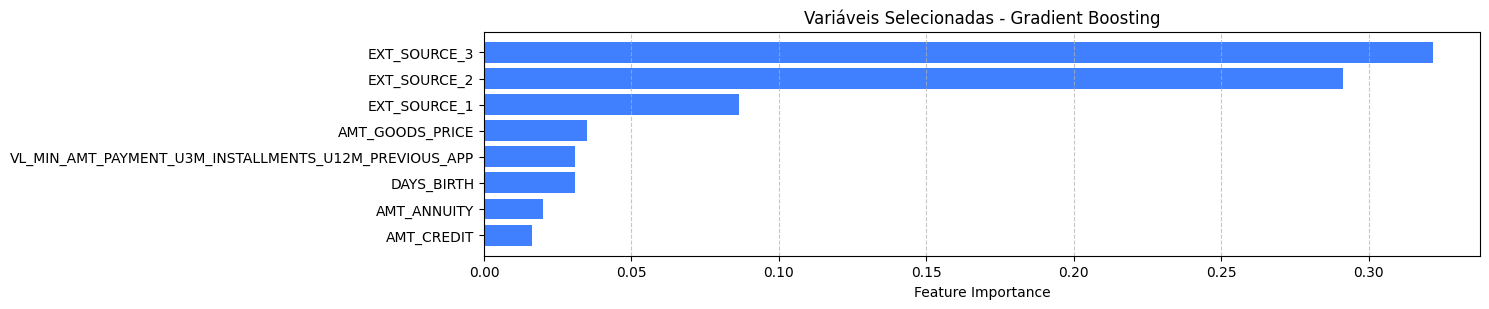

In [35]:
# Ordenando as variáveis por importância.
features = features.sort_values(by='Importance', ascending=True)

# Filtrando o DataFrame para apenas as features acima do corte.
selected_features_df = features[features['Importance'] > cutoff]

# Visualizando a importância das variáveis em barras horizontais.
plt.figure(figsize=(15, len(selected_features_df)*0.4))
plt.barh(selected_features_df['Feature'], selected_features_df['Importance'], color=(0.25, 0.5, 1))
plt.xlabel('Feature Importance')
plt.title('Variáveis Selecionadas - Gradient Boosting')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [36]:
# Salvando a lista de variáveis selecionadas em um arquivo pkl (artefato).
with open(dir_pkl + '/prd_list_features.pkl', 'wb') as f:
    pickle.dump(selected_features, f)

In [37]:
# Carregando a lista do arquivo .pkl.
with open(dir_pkl + '/prd_list_features.pkl', 'rb') as f:
    loaded_lista = pickle.load(f)

print(loaded_lista)

['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP']


In [38]:
# Incluindo a variável target na lista de variáveis explicativas selecionadas.
abt_train_05 = df_train_num[loaded_lista + ['TARGET', 'SK_ID_CURR']]
abt_test_05 = df_test_num[loaded_lista + ['TARGET', 'SK_ID_CURR']]

abt_train_05.shape, abt_test_05.shape

((172205, 10), (43052, 10))

In [39]:
abt_train_05.head()

,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,TARGET,SK_ID_CURR
54931,625500.0,34060.5,625500.0,-19489,0.758916,0.526224,0.510090,4994.550000,0,281575
105184,278811.0,14364.0,189000.0,-21070,0.502984,0.698457,0.367291,7911.140000,0,253241
49525,193500.0,20529.0,193500.0,-11513,0.287588,0.681713,0.150085,20029.939481,0,257591
161471,135000.0,7668.0,135000.0,-21850,0.502984,0.252310,0.510966,20029.939481,0,440634
39438,1288350.0,37800.0,1125000.0,-13273,0.502984,0.161661,0.490258,20029.939481,0,101232


In [40]:
abt_test_05.head()

,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,TARGET,SK_ID_CURR
196348,180000.0,9000.0,180000.0,-9579,0.217777,0.634658,0.554947,13344.890000,0,243431
147976,781920.0,42547.5,675000.0,-20151,0.804014,0.501598,0.384207,20029.939481,0,127962
52662,450000.0,21888.0,450000.0,-11641,0.502984,0.278945,0.300108,20029.939481,1,244667
101577,760225.5,32337.0,679500.0,-10035,0.279232,0.213085,0.556727,20029.939481,0,220032
173078,808650.0,26217.0,675000.0,-16462,0.583032,0.528639,0.510966,20029.939481,0,123746


<br>

### **Salvando o dataset com as variáveis selecionadas**

In [41]:
# Salvando as variáveis selecionadas.
abt_train_05.to_csv(dir_abt + '/abt_train_fs_02.csv', index=False)
abt_test_05.to_csv(dir_abt + '/abt_test_fs_02.csv', index=False)